<a href="https://colab.research.google.com/github/abeliansw/minGPT/blob/master/Colab_Code_Llama_test_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Colab Code Llama*
---

**Colab Code Llama**
A Coding Assistant built on Code Llama.

Copyright ¬© 2023 Trelis LTD. MIT License.

**Colab Code Llama PRO**
- Upload chats and documents.
- Save/re-load chats.
- Get access for ‚Ç¨4.99 ($5.49) [here](https://buy.stripe.com/cN24h2f4pa9ZbQY6oB).

Copyright ¬© 2023 Trelis LTD. Commercial License.

Find Trelis on [HuggingFace](https://huggingface.co/Trelis) and [YouTube](https://www.youtube.com/@TrelisResearch) - for videos on fine-tuning!

## Setup and Installation

- You can run Colab Code Llama on a free Google Colab Notebook.
- Save a copy of this notebook: Go to File -> Save a copy in Drive. (optional, but needed if you want to make changes).
- Go to the menu -> Runtime -> Change Runtime Type - Select GPU (T4).
- Then go to Runtime -> Run all.
- It takes about 2 mins for the installation (which all happens in the cloud in this notebook).
- Once all cells have run, you'll find the chat interface at the bottom.

All of your data remains within your Google Drive and Google's computers.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import time
import random

In [49]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# # 3Í∞úÏùò ÌïÑÎìú Ï†ïÏùò
# TEXT = data.Field(lower = True)
# UD_TAGS = data.Field(unk_token = None)
# PTB_TAGS = data.Field(unk_token = None)

# fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

In [52]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [53]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
num_samples = 33000

In [55]:
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

--2023-09-18 07:09:13--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [56]:
def unicode_to_ascii(s):
  # ÌîÑÎûëÏä§Ïñ¥ ÏïÖÏÑºÌä∏(accent) ÏÇ≠Ï†ú
  # ÏòàÏãú : 'd√©j√† din√©' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [57]:
def preprocess_sentence(sent):
  # ÏïÖÏÑºÌä∏ ÏÇ≠Ï†ú Ìï®Ïàò Ìò∏Ï∂ú
  sent = unicode_to_ascii(sent.lower())

  # Îã®Ïñ¥ÏôÄ Íµ¨ÎëêÏ†ê ÏÇ¨Ïù¥Ïóê Í≥µÎ∞±ÏùÑ ÎßåÎì≠ÎãàÎã§.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¬ø])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") Ïù¥Îì§ÏùÑ Ï†úÏô∏ÌïòÍ≥†Îäî Ï†ÑÎ∂Ä Í≥µÎ∞±ÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # Îã§Ïàò Í∞úÏùò Í≥µÎ∞±ÏùÑ ÌïòÎÇòÏùò Í≥µÎ∞±ÏúºÎ°ú ÏπòÌôò
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [58]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # Í∞Å Îã®Ïñ¥Î≥Ñ Îì±Ïû• ÎπàÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÏó¨ Îì±Ïû• ÎπàÎèÑÍ∞Ä ÎÜíÏùÄ ÏàúÏÑúÎ°ú Ï†ïÎ†¨
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # Îì±Ïû• ÎπàÎèÑÍ∞Ä ÎÜíÏùÄ Îã®Ïñ¥ÏùºÏàòÎ°ù ÎÇÆÏùÄ Ï†ïÏàòÎ•º Î∂ÄÏó¨
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index

In [59]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source Îç∞Ïù¥ÌÑ∞ÏôÄ target Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
      src_line, tar_line, _ = line.strip().split('\t')

      # source Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [60]:
# Ï†ÑÏ≤òÎ¶¨ ÌÖåÏä§Ìä∏
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous d√©j√† din√©?"

print('Ï†ÑÏ≤òÎ¶¨ Ï†Ñ ÏòÅÏñ¥ Î¨∏Ïû• :', en_sent)
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÏòÅÏñ¥ Î¨∏Ïû• :',preprocess_sentence(en_sent))
print('Ï†ÑÏ≤òÎ¶¨ Ï†Ñ ÌîÑÎûëÏä§Ïñ¥ Î¨∏Ïû• :', fr_sent)
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÌîÑÎûëÏä§Ïñ¥ Î¨∏Ïû• :', preprocess_sentence(fr_sent))

Ï†ÑÏ≤òÎ¶¨ Ï†Ñ ÏòÅÏñ¥ Î¨∏Ïû• : Have you had dinner?
Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÏòÅÏñ¥ Î¨∏Ïû• : have you had dinner ?
Ï†ÑÏ≤òÎ¶¨ Ï†Ñ ÌîÑÎûëÏä§Ïñ¥ Î¨∏Ïû• : Avez-vous d√©j√† din√©?
Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÌîÑÎûëÏä§Ïñ¥ Î¨∏Ïû• : avez vous deja dine ?


In [61]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()


In [62]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†• :',sents_en_in[:5])
print('ÎîîÏΩîÎçîÏùò ÏûÖÎ†• :',sents_fra_in[:5])
print('ÎîîÏΩîÎçîÏùò Î†àÏù¥Î∏î :',sents_fra_out[:5])

Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†• : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
ÎîîÏΩîÎçîÏùò ÏûÖÎ†• : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
ÎîîÏΩîÎçîÏùò Î†àÏù¥Î∏î : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


In [63]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("ÏòÅÏñ¥ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : {:d}, ÌîÑÎûëÏä§Ïñ¥ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : {:d}".format(src_vocab_size, tar_vocab_size))

ÏòÅÏñ¥ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 4482, ÌîÑÎûëÏä§Ïñ¥ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 7874


In [64]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

In [65]:
def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [66]:
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 33000/33000 [00:00<00:00, 620322.92it/s]


In [67]:
# ÏÉÅÏúÑ 5Í∞úÏùò ÏÉòÌîåÏóê ÎåÄÌï¥ÏÑú Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ, ÌõÑ Î¨∏Ïû• Ï∂úÎ†•
# Ïù∏ÏΩîÎçî ÏûÖÎ†•Ïù¥ÎØÄÎ°ú <sos>ÎÇò <eos>Í∞Ä ÏóÜÏùå
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
    print(f"Index: {i}, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: {item1}, Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: {item2}")

Index: 0, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: ['go', '.'], Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: [27, 2]
Index: 1, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: ['go', '.'], Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: [27, 2]
Index: 2, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: ['go', '.'], Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: [27, 2]
Index: 3, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: ['go', '.'], Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: [27, 2]
Index: 4, Ï†ïÏàò Ïù∏ÏΩîÎî© Ï†Ñ: ['hi', '.'], Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ: [744, 2]


In [68]:
def pad_sequences(sentences, max_len=None):
    # ÏµúÎåÄ Í∏∏Ïù¥ Í∞íÏù¥ Ï£ºÏñ¥ÏßÄÏßÄ ÏïäÏùÑ Í≤ΩÏö∞ Îç∞Ïù¥ÌÑ∞ ÎÇ¥ ÏµúÎåÄ Í∏∏Ïù¥Î°ú Ìå®Îî©
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [69]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

In [70]:
print('Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†•Ïùò ÌÅ¨Í∏∞(shape) :',encoder_input.shape)
print('ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïùò ÌÅ¨Í∏∞(shape) :',decoder_input.shape)
print('ÎîîÏΩîÎçîÏùò Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞(shape) :',decoder_target.shape)

Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†•Ïùò ÌÅ¨Í∏∞(shape) : (33000, 7)
ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïùò ÌÅ¨Í∏∞(shape) : (33000, 16)
ÎîîÏΩîÎçîÏùò Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞(shape) : (33000, 16)


In [71]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('ÎûúÎç§ ÏãúÌÄÄÏä§ :',indices)

ÎûúÎç§ ÏãúÌÄÄÏä§ : [24455 25115  2022 ... 29198  5744 28172]


In [72]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [73]:
print([index_to_src[word] for word in encoder_input[30997]])
print([index_to_tar[word] for word in decoder_input[30997]])
print([index_to_tar[word] for word in decoder_target[30997]])

['you', 're', 'powerless', '.', '<PAD>', '<PAD>', '<PAD>']
['<sos>', 'tu', 'es', 'depourvu', 'de', 'pouvoir', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['tu', 'es', 'depourvu', 'de', 'pouvoir', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [74]:
n_of_val = int(33000*0.1)
print('Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàò :',n_of_val)

Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàò : 3300


In [75]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [76]:
print('ÌõàÎ†® source Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ :',encoder_input_train.shape)
print('ÌõàÎ†® target Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ :',decoder_input_train.shape)
print('ÌõàÎ†® target Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞ :',decoder_target_train.shape)
print('ÌÖåÏä§Ìä∏ source Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ :',encoder_input_test.shape)
print('ÌÖåÏä§Ìä∏ target Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ :',decoder_input_test.shape)
print('ÌÖåÏä§Ìä∏ target Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞ :',decoder_target_test.shape)

ÌõàÎ†® source Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ : (29700, 7)
ÌõàÎ†® target Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ : (29700, 16)
ÌõàÎ†® target Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞ : (29700, 16)
ÌÖåÏä§Ìä∏ source Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ : (3300, 7)
ÌÖåÏä§Ìä∏ target Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞ : (3300, 16)
ÌÖåÏä§Ìä∏ target Î†àÏù¥Î∏îÏùò ÌÅ¨Í∏∞ : (3300, 16)


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)
        # hidden.shape == (1, batch_size, hidden_units), cell.shape == (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x)
        # Ïù∏ÏΩîÎçîÏùò Ï∂úÎ†•ÏùÄ hidden state, cell state
        return output,hidden, cell

class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size)

    def forward(self, x, hidden, cell):

        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)

        # ÎîîÏΩîÎçîÏùò LSTMÏúºÎ°ú Ïù∏ÏΩîÎçîÏùò hidden state, cell stateÎ•º Ï†ÑÎã¨.
        # output.shape == (batch_size, seq_len, hidden_units)
        # hidden.shape == (1, batch_size, hidden_units)
        # cell.shape == (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        # output.shape: (batch_size, seq_len, tar_vocab_size)
        output = self.fc(output)

        # ÎîîÏΩîÎçîÏùò Ï∂úÎ†•ÏùÄ ÏòàÏ∏°Í∞í, hidden state, cell state
        return output, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        otuputdummy,hidden, cell = self.encoder(src)

        # ÌõàÎ†® Ï§ëÏóêÎäî ÎîîÏΩîÎçîÏùò Ï∂úÎ†• Ï§ë Ïò§ÏßÅ outputÎßå ÏÇ¨Ïö©ÌïúÎã§.
        output, _, _ = self.decoder(trg, hidden, cell)
        return output

encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [100]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4482, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7874, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7874, bias=True)
  )
)


In [101]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # ÏàúÎ∞©Ìñ• Ï†ÑÌåå
            # outputs.shape == (batch_size, seq_len, tar_vocab_size)
            outputs = model(encoder_inputs, decoder_inputs)

            # ÏÜêÏã§ Í≥ÑÏÇ∞
            # outputs.view(-1, outputs.size(-1))Ïùò shapeÎäî (batch_size * seq_len, tar_vocab_size)
            # decoder_targets.view(-1)Ïùò shapeÎäî (batch_size * seq_len)
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ (Ìå®Îî© ÌÜ†ÌÅ∞ Ï†úÏô∏)
            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count

In [102]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

# Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è Îç∞Ïù¥ÌÑ∞Î°úÎçî ÏÉùÏÑ±
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# ÌïôÏäµ ÏÑ§Ï†ï
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4482, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7874, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7874, bias=True)
  )
)

In [103]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # ÌõàÎ†® Î™®Îìú
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî
        optimizer.zero_grad()

        # ÏàúÎ∞©Ìñ• Ï†ÑÌåå
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # ÏÜêÏã§ Í≥ÑÏÇ∞ Î∞è Ïó≠Î∞©Ìñ• Ï†ÑÌåå
        # outputs.view(-1, outputs.size(-1))Ïùò shapeÎäî (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)Ïùò shapeÎäî (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ ÏµúÏÜåÏùº Îïå Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch: 1/30 | Train Loss: 2.9408 | Train Acc: 0.5305 | Valid Loss: 3.0669 | Valid Acc: 0.5243
Validation loss improved from inf to 3.0669. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.
Epoch: 2/30 | Train Loss: 2.2902 | Train Acc: 0.5991 | Valid Loss: 2.5391 | Valid Acc: 0.5822
Validation loss improved from 3.0669 to 2.5391. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.
Epoch: 3/30 | Train Loss: 1.8764 | Train Acc: 0.6442 | Valid Loss: 2.2359 | Valid Acc: 0.6195
Validation loss improved from 2.5391 to 2.2359. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.
Epoch: 4/30 | Train Loss: 1.5702 | Train Acc: 0.6848 | Valid Loss: 2.0446 | Valid Acc: 0.6431
Validation loss improved from 2.2359 to 2.0446. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.
Epoch: 5/30 | Train Loss: 1.3147 | Train Acc: 0.7190 | Valid Loss: 1.8936 | Valid Acc: 0.6647
Validation loss improved from 2.0446 to 1.8936. Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î•º Ï†ÄÏû•Ìï©ÎãàÎã§.
Epoch: 6/30 | Train Loss: 1.0975 | Train Acc: 0.7553 | Valid Loss: 1.7853 | Valid Acc: 0.6784
Validation loss imp

In [104]:
# Î™®Îç∏ Î°úÎìú
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# Î™®Îç∏ÏùÑ deviceÏóê Ïò¨Î¶ΩÎãàÎã§.
model.to(device)

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Ï†ïÌôïÎèÑÏôÄ ÏÜêÏã§ Í≥ÑÏÇ∞
val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 1.5226
Best model validation accuracy: 0.7247


In [105]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])

3
4


In [106]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

# ÏõêÎ¨∏Ïùò Ï†ïÏàò ÏãúÌÄÄÏä§Î•º ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# Î≤àÏó≠Î¨∏Ïùò Ï†ïÏàò ÏãúÌÄÄÏä§Î•º ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [107]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

[   3   21 1449    2    0    0    0]
[   3   14   17   61 3071    2    0    0    0    0    0    0    0    0
    0    0]
[  14   17   61 3071    2    4    0    0    0    0    0    0    0    0
    0    0]


In [109]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # Ïù∏ÏΩîÎçîÏùò Ï¥àÍ∏∞ ÏÉÅÌÉú ÏÑ§Ï†ï
    outputdummy, hidden, cell = model.encoder(encoder_inputs)

    # ÏãúÏûë ÌÜ†ÌÅ∞ <sos>ÏùÑ ÎîîÏΩîÎçîÏùò Ï≤´ ÏûÖÎ†•ÏúºÎ°ú ÏÑ§Ï†ï
    # unsqueeze(0)Îäî Î∞∞Ïπò Ï∞®ÏõêÏùÑ Ï∂îÍ∞ÄÌïòÍ∏∞ ÏúÑÌï®.
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # forÎ¨∏ÏùÑ ÎèÑÎäî Í≤É == ÎîîÏΩîÎçîÏùò Í∞Å ÏãúÏ†ê
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # ÏÜåÌîÑÌä∏Îß•Ïä§ ÌöåÍ∑ÄÎ•º ÏàòÌñâ. ÏòàÏ∏° Îã®Ïñ¥Ïùò Ïù∏Îç±Ïä§
        output_token = output.argmax(dim=-1).item()

        # Ï¢ÖÎ£å ÌÜ†ÌÅ∞ <eos>
        if output_token == 4:
            break

        # Í∞Å ÏãúÏ†êÏùò Îã®Ïñ¥(Ï†ïÏàò)Îäî decoded_tokensÏóê ÎàÑÏ†ÅÌïòÏòÄÎã§Í∞Ä ÏµúÏ¢Ö Î≤àÏó≠ ÏãúÌÄÄÏä§Î°ú Î¶¨ÌÑ¥Ìï©ÎãàÎã§.
        decoded_tokens.append(output_token)

        # ÌòÑÏû¨ ÏãúÏ†êÏùò ÏòàÏ∏°. Îã§Ïùå ÏãúÏ†êÏùò ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÎêúÎã§.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [110]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("ÏûÖÎ†•Î¨∏Ïû• :",seq_to_src(encoder_input_train[seq_index]))
  print("Ï†ïÎãµÎ¨∏Ïû• :",seq_to_tar(decoder_input_train[seq_index]))
  print("Î≤àÏó≠Î¨∏Ïû• :",translated_text)
  print("-"*50)

ÏûÖÎ†•Î¨∏Ïû• : i work out . 
Ï†ïÎãµÎ¨∏Ïû• : je fais de l exercice . 
Î≤àÏó≠Î¨∏Ïû• : je fais de l exercice .
--------------------------------------------------
ÏûÖÎ†•Î¨∏Ïû• : you re a traitor . 
Ï†ïÎãµÎ¨∏Ïû• : tu es une traitresse . 
Î≤àÏó≠Î¨∏Ïû• : tu es une traitresse .
--------------------------------------------------
ÏûÖÎ†•Î¨∏Ïû• : nobody complained . 
Ï†ïÎãµÎ¨∏Ïû• : personne ne se plaignait . 
Î≤àÏó≠Î¨∏Ïû• : personne ne s est plaint .
--------------------------------------------------
ÏûÖÎ†•Î¨∏Ïû• : take a good look . 
Ï†ïÎãµÎ¨∏Ïû• : regarde bien . 
Î≤àÏó≠Î¨∏Ïû• : regarde bien .
--------------------------------------------------
ÏûÖÎ†•Î¨∏Ïû• : do you like music ? 
Ï†ïÎãµÎ¨∏Ïû• : aimes tu la musique ? 
Î≤àÏó≠Î¨∏Ïû• : est ce que tu aimes la musique ?
--------------------------------------------------


In [124]:
index_to_src[0]

'<PAD>'

In [111]:
input_seq = encoder_input_train[3]
input_seq

array([ 3, 84, 55,  2,  0,  0,  0])

In [112]:
encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

In [113]:
encoder_inputs

tensor([[ 3, 84, 55,  2,  0,  0,  0]], device='cuda:0')

In [114]:
output,hidden, cell = model.encoder(encoder_inputs)

In [119]:
output[0][6].shape

torch.Size([256])

In [117]:
output.shape

torch.Size([1, 7, 256])

In [120]:
hidden

tensor([[[-0.8759, -0.0691, -0.0964,  0.0075,  0.4220,  0.8102,  0.9525,
          -0.1077,  0.9106, -0.7326, -0.6970, -0.3313, -0.7677, -0.3743,
           0.0119,  0.1832, -0.7186,  0.2133, -0.5386, -0.8387,  0.7440,
          -0.4301,  0.0164,  0.7945, -0.6960, -0.0293, -0.9531,  0.8219,
          -0.0523, -0.9575, -0.9652, -0.9898,  0.0516, -0.6132,  0.2589,
          -0.0210,  0.0681, -0.5617, -0.8303, -0.8775,  0.8086, -0.0721,
          -0.2777, -0.5622,  0.2788,  0.1055, -0.7330, -0.9166, -0.0511,
          -0.6573, -0.1249, -0.2548,  0.9832, -0.1313,  0.9215, -0.9290,
           0.1355,  0.7633, -0.6480, -0.4312, -0.0645, -0.3836, -0.0181,
          -0.6908, -0.6135,  0.5793,  0.3639,  0.8586,  0.4374,  0.8753,
           0.5747,  0.5709, -0.0698, -0.6892, -0.0567,  0.5923,  0.9674,
          -0.7887, -0.4878, -0.2305, -0.6045,  0.9272,  0.8808, -0.4711,
           0.3124, -0.9883, -0.1103, -0.8357,  0.6408,  0.4309, -0.0099,
           0.9119, -0.2098,  0.1841, -0.1080, -0.76

In [121]:
hidden.shape

torch.Size([1, 1, 256])

In [122]:
cell

tensor([[[-3.4479, -0.1819, -4.3606,  0.0462,  0.7807,  2.3267,  1.9611,
          -4.0978,  1.9199, -1.6732, -0.8741, -5.7136, -1.5367, -0.4078,
           4.9234,  1.6715, -2.2930,  0.2882, -0.7252, -1.6870,  1.1240,
          -3.0957,  3.8598,  2.3474, -0.8871, -0.0297, -2.4062,  1.2422,
          -2.9709, -2.6544, -3.3263, -2.9094,  3.0072, -2.1564,  0.2686,
          -0.1293,  4.5799, -0.7175, -2.9413, -3.0756,  1.2091, -4.4428,
          -3.1458, -3.3022,  5.1905,  3.2341, -2.7101, -1.9276, -3.2168,
          -1.0942, -3.8260, -0.4210,  2.4294, -4.4110,  1.7368, -3.1293,
           1.3562,  1.1278, -1.8521, -0.8833, -2.7864, -0.4465, -4.0914,
          -0.8514, -0.7947,  0.8074,  0.4449,  1.7084,  2.5040,  2.1729,
           2.0569,  0.8107, -3.3704, -0.8576, -2.4375,  0.6862,  2.1301,
          -3.1624, -0.5785, -0.8202, -0.8460,  1.9516,  1.5733, -0.5287,
           1.2694, -2.8541, -2.9061, -1.5974,  1.5245,  2.6059, -0.3515,
           2.5105, -0.2245,  0.1863, -3.3129, -1.41

In [123]:
cell.shape

torch.Size([1, 1, 256])

In [125]:
decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)

decoded_tokens = []

In [126]:
output, hidden, cell = model.decoder(decoder_input, hidden, cell)

In [128]:
output

tensor([[[-8.3560, -9.0641, -3.6764,  ..., -6.5973, -7.5356, -8.1889]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [129]:
output.shape

torch.Size([1, 1, 7874])

In [130]:
hidden.shape

torch.Size([1, 1, 256])

In [131]:
cell.shape

torch.Size([1, 1, 256])

In [132]:
output_token = output.argmax(dim=-1).item()

In [133]:
output_token

5

In [135]:
index_to_tar[output_token]

'je'

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
print(word_tokenize(en_text))

['A', 'Dog', 'Run', 'back', 'corner', 'near', 'spare', 'bedrooms']


In [ ]:
kor_text = "ÏÇ¨Í≥ºÏùò ÎÜÄÎùºÏö¥ Ìö®Îä•Ïù¥ÎùºÎäî Í∏ÄÏùÑ Î¥§Ïñ¥. Í∑∏ÎûòÏÑú Ïò§Îäò ÏÇ¨Í≥ºÎ•º Î®πÏúºÎ†§Í≥† ÌñàÎäîÎç∞ ÏÇ¨Í≥ºÍ∞Ä Ïç©Ïñ¥ÏÑú ÏäàÌçºÏóê Í∞ÄÏÑú ÏÇ¨Í≥ºÎûë Ïò§Î†åÏßÄ ÏÇ¨ÏôîÏñ¥"

In [ ]:
print(kor_text.split())

['ÏÇ¨Í≥ºÏùò', 'ÎÜÄÎùºÏö¥', 'Ìö®Îä•Ïù¥ÎùºÎäî', 'Í∏ÄÏùÑ', 'Î¥§Ïñ¥.', 'Í∑∏ÎûòÏÑú', 'Ïò§Îäò', 'ÏÇ¨Í≥ºÎ•º', 'Î®πÏúºÎ†§Í≥†', 'ÌñàÎäîÎç∞', 'ÏÇ¨Í≥ºÍ∞Ä', 'Ïç©Ïñ¥ÏÑú', 'ÏäàÌçºÏóê', 'Í∞ÄÏÑú', 'ÏÇ¨Í≥ºÎûë', 'Ïò§Î†åÏßÄ', 'ÏÇ¨ÏôîÏñ¥']


In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
print(tokenizer.morphs(kor_text))

['ÏÇ¨Í≥º', 'Ïùò', 'ÎÜÄÎùºÏö¥', 'Ìö®Îä•', 'Ïù¥', 'ÎùºÎäî', 'Í∏Ä', 'ÏùÑ', 'Î¥§', 'Ïñ¥', '.', 'Í∑∏ÎûòÏÑú', 'Ïò§Îäò', 'ÏÇ¨Í≥º', 'Î•º', 'Î®π', 'ÏúºÎ†§Í≥†', 'Ìñà', 'ÎäîÎç∞', 'ÏÇ¨Í≥º', 'Í∞Ä', 'Ïç©', 'Ïñ¥ÏÑú', 'ÏäàÌçº', 'Ïóê', 'Í∞Ä', 'ÏÑú', 'ÏÇ¨Í≥º', 'Îûë', 'Ïò§Î†åÏßÄ', 'ÏÇ¨', 'Ïôî', 'Ïñ¥']


In [ ]:
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
from nltk import FreqDist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
data = pd.read_table('ratings.txt') # Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ï†ÄÏû•
data[:10]

id                                           document  label
0   8112052                                Ïñ¥Î¶¥ÎïåÎ≥¥Í≥† ÏßÄÍ∏àÎã§ÏãúÎ¥êÎèÑ Ïû¨Î∞åÏñ¥Ïöî„Öã„Öã      1
1   8132799  ÎîîÏûêÏù∏ÏùÑ Î∞∞Ïö∞Îäî ÌïôÏÉùÏúºÎ°ú, Ïô∏Íµ≠ÎîîÏûêÏù¥ÎÑàÏôÄ Í∑∏Îì§Ïù¥ ÏùºÍµ∞ Ï†ÑÌÜµÏùÑ ÌÜµÌï¥ Î∞úÏ†ÑÌï¥Í∞ÄÎäî Î¨∏ÌôîÏÇ∞...      1
2   4655635               Ìè¥Î¶¨Ïä§Ïä§ÌÜ†Î¶¨ ÏãúÎ¶¨Ï¶àÎäî 1Î∂ÄÌÑ∞ Îâ¥ÍπåÏßÄ Î≤ÑÎ¶¥Íªò ÌïòÎÇòÎèÑ ÏóÜÏùå.. ÏµúÍ≥†.      1
3   9251303  ÏôÄ.. Ïó∞Í∏∞Í∞Ä ÏßÑÏßú Í∞úÏ©îÍµ¨ÎÇò.. ÏßÄÎ£®Ìï†Í±∞ÎùºÍ≥† ÏÉùÍ∞ÅÌñàÎäîÎç∞ Î™∞ÏûÖÌï¥ÏÑú Î¥§Îã§.. Í∑∏Îûò Ïù¥Îü∞...      1
4  10067386                        ÏïàÍ∞ú ÏûêÏö±Ìïú Î∞§ÌïòÎäòÏóê Îñ† ÏûàÎäî Ï¥àÏäπÎã¨ Í∞ôÏùÄ ÏòÅÌôî.      1
5   2190435                      ÏÇ¨ÎûëÏùÑ Ìï¥Î≥∏ÏÇ¨ÎûåÏù¥ÎùºÎ©¥ Ï≤òÏùåÎ∂ÄÌÑ∞ ÎÅùÍπåÏßÄ ÏõÉÏùÑÏàò ÏûàÎäîÏòÅÌôî      1
6   9279041                                   ÏôÑÏ†Ñ Í∞êÎèôÏûÖÎãàÎã§ Îã§ÏãúÎ¥êÎèÑ Í∞êÎèô      1
7   7865729                        Í∞úÎì§Ïùò Ï†ÑÏüÅ2 ÎÇòÏò§ÎÇòÏöî? ÎÇòÏò§Î©¥ 1Îπ†Î°ú Î≥¥Í≥† Ïã∂Ïùå      1
8   7477618                                                  Íµø      1
9   9250537                                     Î∞îÎ≥¥Í∞Ä ÏïÑÎãàÎùº Î≥ë Ïâ∞ Ïù∏ÎìØ      1

In [ ]:
sample_data = data[:100] # ÏûÑÏùòÎ°ú 100Í∞úÎßå Ï†ÄÏû•

In [ ]:
sample_data['document'] = sample_data['document'].str.replace("[^„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£ ]","")
# ÌïúÍ∏ÄÍ≥º Í≥µÎ∞±ÏùÑ Ï†úÏô∏ÌïòÍ≥† Î™®Îëê Ï†úÍ±∞
sample_data[:10]

<ipython-input-19-2131f05301ae>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sample_data['document'] = sample_data['document'].str.replace("[^„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£ ]","")
<ipython-input-19-2131f05301ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['document'] = sample_data['document'].str.replace("[^„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£ ]","")


id                                           document  label
0   8112052                                Ïñ¥Î¶¥ÎïåÎ≥¥Í≥† ÏßÄÍ∏àÎã§ÏãúÎ¥êÎèÑ Ïû¨Î∞åÏñ¥Ïöî„Öã„Öã      1
1   8132799  ÎîîÏûêÏù∏ÏùÑ Î∞∞Ïö∞Îäî ÌïôÏÉùÏúºÎ°ú Ïô∏Íµ≠ÎîîÏûêÏù¥ÎÑàÏôÄ Í∑∏Îì§Ïù¥ ÏùºÍµ∞ Ï†ÑÌÜµÏùÑ ÌÜµÌï¥ Î∞úÏ†ÑÌï¥Í∞ÄÎäî Î¨∏ÌôîÏÇ∞ÏóÖ...      1
2   4655635                   Ìè¥Î¶¨Ïä§Ïä§ÌÜ†Î¶¨ ÏãúÎ¶¨Ï¶àÎäî Î∂ÄÌÑ∞ Îâ¥ÍπåÏßÄ Î≤ÑÎ¶¥Íªò ÌïòÎÇòÎèÑ ÏóÜÏùå ÏµúÍ≥†      1
3   9251303   ÏôÄ Ïó∞Í∏∞Í∞Ä ÏßÑÏßú Í∞úÏ©îÍµ¨ÎÇò ÏßÄÎ£®Ìï†Í±∞ÎùºÍ≥† ÏÉùÍ∞ÅÌñàÎäîÎç∞ Î™∞ÏûÖÌï¥ÏÑú Î¥§Îã§ Í∑∏Îûò Ïù¥Îü∞Í≤å ÏßÑÏßú ÏòÅÌôîÏßÄ      1
4  10067386                         ÏïàÍ∞ú ÏûêÏö±Ìïú Î∞§ÌïòÎäòÏóê Îñ† ÏûàÎäî Ï¥àÏäπÎã¨ Í∞ôÏùÄ ÏòÅÌôî      1
5   2190435                      ÏÇ¨ÎûëÏùÑ Ìï¥Î≥∏ÏÇ¨ÎûåÏù¥ÎùºÎ©¥ Ï≤òÏùåÎ∂ÄÌÑ∞ ÎÅùÍπåÏßÄ ÏõÉÏùÑÏàò ÏûàÎäîÏòÅÌôî      1
6   9279041                                   ÏôÑÏ†Ñ Í∞êÎèôÏûÖÎãàÎã§ Îã§ÏãúÎ¥êÎèÑ Í∞êÎèô      1
7   7865729                           Í∞úÎì§Ïùò Ï†ÑÏüÅ ÎÇòÏò§ÎÇòÏöî ÎÇòÏò§Î©¥ Îπ†Î°ú Î≥¥Í≥† Ïã∂Ïùå      1
8   7477618                                                  Íµø      1
9   9250537                                     Î∞îÎ≥¥Í∞Ä ÏïÑÎãàÎùº Î≥ë Ïâ∞ Ïù∏ÎìØ      1

In [ ]:
# Î∂àÏö©Ïñ¥ Ï†ïÏùò
stopwords=['Ïùò','Í∞Ä','Ïù¥','ÏùÄ','Îì§','Îäî','Ï¢Ä','Ïûò','Í±ç','Í≥º','ÎèÑ','Î•º','ÏúºÎ°ú','Ïûê','Ïóê','ÏôÄ','Ìïú','ÌïòÎã§']

In [ ]:
tokenizer = Mecab()
tokenized=[]
for sentence in sample_data['document']:
    temp = tokenizer.morphs(sentence) # ÌÜ†ÌÅ∞Ìôî
    temp = [word for word in temp if not word in stopwords] # Î∂àÏö©Ïñ¥ Ï†úÍ±∞
    tokenized.append(temp)

In [ ]:
print(tokenized[:10])

[['Ïñ¥Î¶¥', 'Îïå', 'Î≥¥', 'Í≥†', 'ÏßÄÍ∏à', 'Îã§Ïãú', 'Î¥êÎèÑ', 'Ïû¨Î∞å', 'Ïñ¥Ïöî', '„Öã„Öã'], ['ÎîîÏûêÏù∏', 'ÏùÑ', 'Î∞∞Ïö∞', 'ÌïôÏÉù', 'Ïô∏Íµ≠', 'ÎîîÏûêÏù¥ÎÑà', 'Í∑∏', 'ÏùºÍµ∞', 'Ï†ÑÌÜµ', 'ÏùÑ', 'ÌÜµÌï¥', 'Î∞úÏ†Ñ', 'Ìï¥', 'Î¨∏Ìôî', 'ÏÇ∞ÏóÖ', 'Î∂ÄÎü¨Ïõ†', 'ÎäîÎç∞', 'ÏÇ¨Ïã§', 'Ïö∞Î¶¨', 'ÎÇòÎùº', 'ÏóêÏÑú', 'Í∑∏', 'Ïñ¥Î†§Ïö¥', 'ÏãúÏ†à', 'ÎÅù', 'ÍπåÏßÄ', 'Ïó¥Ï†ï', 'ÏùÑ', 'ÏßÄÌÇ®', 'ÎÖ∏ÎùºÎÖ∏', 'Í∞ô', 'Ï†ÑÌÜµ', 'Ïûà', 'Ïñ¥', 'Ï†Ä', 'Í∞ô', 'ÏÇ¨Îûå', 'Íøà', 'ÏùÑ', 'Íæ∏', 'Í≥†', 'Ïù¥Î§ÑÎÇòÍ∞à', 'Ïàò', 'Ïûà', 'Îã§Îäî', 'Í≤É', 'Í∞êÏÇ¨', 'Ìï©ÎãàÎã§'], ['Ìè¥Î¶¨Ïä§', 'Ïä§ÌÜ†Î¶¨', 'ÏãúÎ¶¨Ï¶à', 'Î∂ÄÌÑ∞', 'Îâ¥', 'ÍπåÏßÄ', 'Î≤ÑÎ¶¥', 'Íªò', 'ÌïòÎÇò', 'ÏóÜ', 'Ïùå', 'ÏµúÍ≥†'], ['Ïó∞Í∏∞', 'ÏßÑÏßú', 'Í∞ú', 'Ï©î', 'Íµ¨ÎÇò', 'ÏßÄÎ£®', 'Ìï†Í±∞', 'ÎùºÍ≥†', 'ÏÉùÍ∞Å', 'Ìñà', 'ÎäîÎç∞', 'Î™∞ÏûÖ', 'Ìï¥ÏÑú', 'Î¥§', 'Îã§', 'Í∑∏Îûò', 'Ïù¥Îü∞', 'Í≤å', 'ÏßÑÏßú', 'ÏòÅÌôî', 'ÏßÄ'], ['ÏïàÍ∞ú', 'ÏûêÏö±', 'Î∞§ÌïòÎäò', 'Îñ†', 'Ïûà', 'Ï¥àÏäπÎã¨', 'Í∞ô', 'ÏòÅÌôî'], ['ÏÇ¨Îûë', 'ÏùÑ', 'Ìï¥', 'Î≥∏', 'ÏÇ¨Îûå', 'ÎùºÎ©¥', 'Ï≤òÏùå', 'Î∂

In [ ]:
vocab = FreqDist(np.hstack(tokenized))
print('Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : {}'.format(len(vocab)))

Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 664


In [ ]:
vocab_size = 500
# ÏÉÅÏúÑ vocab_sizeÍ∞úÏùò Îã®Ïñ¥Îßå Î≥¥Ï°¥
vocab = vocab.most_common(vocab_size)
print('Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : {}'.format(len(vocab)))

Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 500


In [ ]:
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 1
word_to_index['unk'] = 0

In [ ]:
encoded = []
for line in tokenized: #ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ÏóêÏÑú 1Ï§ÑÏî© Î¨∏Ïû•ÏùÑ ÏùΩÏùå
    temp = []
    for w in line: #Í∞Å Ï§ÑÏóêÏÑú 1Í∞úÏî© Í∏ÄÏûêÎ•º ÏùΩÏùå
      try:
        temp.append(word_to_index[w]) # Í∏ÄÏûêÎ•º Ìï¥ÎãπÎêòÎäî Ï†ïÏàòÎ°ú Î≥ÄÌôò
      except KeyError: # Îã®Ïñ¥ ÏßëÌï©Ïóê ÏóÜÎäî Îã®Ïñ¥Ïùº Í≤ΩÏö∞ unkÎ°ú ÎåÄÏ≤¥ÎêúÎã§.
        temp.append(word_to_index['unk']) # unkÏùò Ïù∏Îç±Ïä§Î°ú Î≥ÄÌôò

    encoded.append(temp)

In [ ]:
print(encoded[:10])


[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11], [45, 33, 119, 210, 211, 212, 213, 69, 46, 34, 13, 214, 120, 15, 2, 215, 70, 8, 33, 3, 35], [216, 217, 218, 219, 7, 220, 17, 3], [121, 5, 24, 36, 44, 122, 123, 53, 117, 31, 85, 5, 14, 7, 3], [124, 37, 221, 42, 80, 37], [119, 222, 55, 223, 55, 86, 224, 38, 9, 4, 47, 25], [56], [225, 87, 88, 226, 227, 57, 89]]


Î¶¨Î∑∞Ïùò ÏµúÎåÄ Í∏∏Ïù¥ : 62
Î¶¨Î∑∞Ïùò ÏµúÏÜå Í∏∏Ïù¥ : 1
Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ : 13.900000


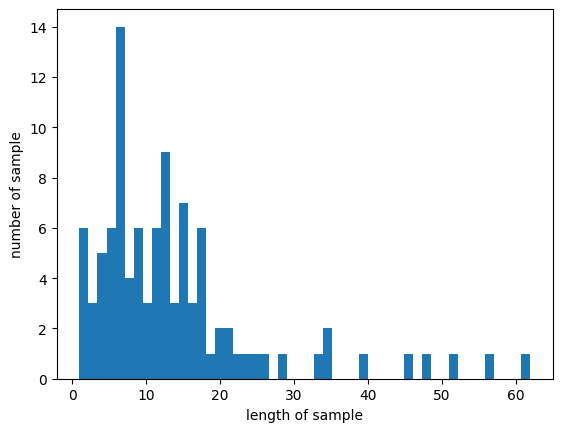

In [ ]:
max_len = max(len(l) for l in encoded)
print('Î¶¨Î∑∞Ïùò ÏµúÎåÄ Í∏∏Ïù¥ : %d' % max_len)
print('Î¶¨Î∑∞Ïùò ÏµúÏÜå Í∏∏Ïù¥ : %d' % min(len(l) for l in encoded))
print('Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ : %f' % (sum(map(len, encoded))/len(encoded)))
plt.hist([len(s) for s in encoded], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [ ]:
for line in encoded:
    if len(line) < max_len: # ÌòÑÏû¨ ÏÉòÌîåÏù¥ Ï†ïÌï¥Ï§Ä Í∏∏Ïù¥Î≥¥Îã§ ÏßßÏúºÎ©¥
        line += [word_to_index['pad']] * (max_len - len(line)) # ÎÇòÎ®∏ÏßÄÎäî Ï†ÑÎ∂Ä 'pad' ÌÜ†ÌÅ∞ÏúºÎ°ú Ï±ÑÏö¥Îã§.

In [ ]:
[word_to_index['pad']]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print('Î¶¨Î∑∞Ïùò ÏµúÎåÄ Í∏∏Ïù¥ : %d' % max(len(l) for l in encoded))
print('Î¶¨Î∑∞Ïùò ÏµúÏÜå Í∏∏Ïù¥ : %d' % min(len(l) for l in encoded))
print('Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ : %f' % (sum(map(len, encoded))/len(encoded)))

Î¶¨Î∑∞Ïùò ÏµúÎåÄ Í∏∏Ïù¥ : 62
Î¶¨Î∑∞Ïùò ÏµúÏÜå Í∏∏Ïù¥ : 62
Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ : 62.000000


In [ ]:
 max(len(l) for l in encoded)

62

In [ ]:
print(encoded[:3])

[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [ ]:
import urllib.request
import pandas as pd

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7e558272fee0>)

In [ ]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

review  sentiment
0  My family and I normally do not watch local mo...          1
1  Believe it or not, this was at one time the wo...          0
2  After some internet surfing, I found the "Home...          0
3  One of the most unheralded great works of anim...          1
4  It was the Sixties, and anyone with long hair ...          0

In [ ]:
print('Ï†ÑÏ≤¥ ÏÉòÌîåÏùò Í∞úÏàò : {}'.format(len(df)))

Ï†ÑÏ≤¥ ÏÉòÌîåÏùò Í∞úÏàò : 50000


In [ ]:
train_df = df[:25000]
test_df = df[25000:]

In [ ]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

In [ ]:
train_df.to_csv("/content/drive/MyDrive/test/train_data.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/test/test_data.csv", index=False)

In [ ]:
from torchtext.legacy import data # torchtext.data ÏûÑÌè¨Ìä∏

# ÌïÑÎìú Ï†ïÏùò
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

ModuleNotFoundError: ignored

In [ ]:
# Configuration
runtimeFlag = "cuda:0" #Run on GPU (you can't run GPTQ on cpu)
cache_dir = None # by default, don't set a cache directory. This is automatically updated if you connect Google Drive.
scaling_factor = 1.0 # allows for a max sequence length of 16384*6 = 98304! Unfortunately, requires Colab Pro and a V100 or A100 to have sufficient RAM.

In [ ]:
# Set the SYSTEM PROMPT
DEFAULT_SYSTEM_PROMPT = 'You are a helpful pair-coding assistant.'
SYSTEM_PROMPT = DEFAULT_SYSTEM_PROMPT

print(SYSTEM_PROMPT)

You are a helpful pair-coding assistant.


### Google Drive Mounting (optional)
- Allows you to download the model to Google Drive for faster startup next time.

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ## Allow the model to be saved to Google Drive for faster startup next time

# # This is the path to the Google Drive folder.
# drive_path = "/content/drive"

# # This is the path where you want to store your cache.
# cache_dir_path = os.path.join(drive_path, "My Drive/huggingface_cache")

# # Check if the Google Drive folder exists. If it does, use it as the cache_dir.
# # If not, set cache_dir to None to use the default Hugging Face cache location.
# if os.path.exists(drive_path):
#     cache_dir = cache_dir_path
#     os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists
# else:
#     cache_dir = None

# print(cache_dir)

## Install

In [ ]:
!pip install -q -U transformers peft accelerate optimum

!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.6/7.6 MB 17.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 85.6/85.6 kB 9.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 251.2/251.2 kB 24.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 380.6/380.6 kB 28.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [ ]:
!pip install -q -U pdfminer.six # could maybe add pre-built wheels to speed this up.

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5.6/5.6 MB 47.7 MB/s eta 0:00:00


In [ ]:
# https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Import

In [ ]:
import transformers
import torch
import json
import os
from transformers import AutoTokenizer, TextStreamer

## Load Model
If you have connected to Google Drive, the model will load from there (unless this is your first time connecting, in which case the model will be saved to Drive).
- Takes about 2 mins first time around.
- Takes about 1 min the 2nd time onwards with Google Drive.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # rope_scaling = {"type": "dynamic", "factor": scaling_factor}
    )
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
print(model.config.max_position_embeddings)

16384


In [ ]:
print(model.config)

LlamaConfig {
  "_name_or_path": "TheBloke/CodeLlama-13B-Instruct-GPTQ",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "TheBloke/CodeLlama-13B-Instruct-GPTQ--configuration_llama.LlamaConfig",
    "AutoModel": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaModel",
    "AutoModelForCausalLM": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaForCausalLM",
    "AutoModelForSequenceClassification": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaForSequenceClassification"
  },
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 5120,
  "initializer_range": 0.02,
  "intermediate_size": 13824,
  "max_position_embeddings": 16384,
  "model_type": "llama",
  "num_attention_heads": 40,
  "num_hidden_layers": 40,
  "num_key_value_heads": 40,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "batch_size": 1,
    "bits": 4,
    "block_name_to_quantize": null,
    "damp_percen

## Set up the User Interface

In [ ]:
from IPython.display import display, HTML, clear_output, Markdown
import textwrap, json
import ipywidgets as widgets
import re, time
from google.colab import files
from pdfminer.high_level import extract_text
import io

In [ ]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

# max_doc_length = 50
max_context = int(model.config.max_position_embeddings*scaling_factor)
max_doc_length = int(0.75 * max_context)  # max doc length is 75% of the context length
max_doc_words = int(max_doc_length)

In [ ]:
def generate_response(dialogs, temperature=0.01, top_p=0.9, logprobs=False):
    torch.cuda.empty_cache()
    # print(json.dumps(dialogs, indent=4))
    max_prompt_len = int(0.85 * max_context)
    max_gen_len = int(0.10 * max_prompt_len)

    prompt_tokens = []
    for dialog in dialogs:
        if dialog[0]["role"] != "system":
            dialog = [
                {
                    "role": "system",
                    "content": SYSTEM_PROMPT,
                }
            ] + dialog
        dialog_tokens = [tokenizer(
            f"{B_INST} {B_SYS}{(dialog[0]['content']).strip()}{E_SYS}{(dialog[1]['content']).strip()} {E_INST}",
            # f"{B_INST} {(dialog[1]['content']).strip()} {E_INST}", # Omits the system prompt altogether
            return_tensors="pt",
            add_special_tokens=True
        ).input_ids.to(runtimeFlag)]
        for i in range(2, len(dialog), 2):
            user_tokens = tokenizer(
                f"{B_INST} {(dialog[i+1]['content']).strip()} {E_INST}",
                return_tensors="pt",
                add_special_tokens=True
            ).input_ids.to(runtimeFlag)
            assistant_w_eos = dialog[i]['content'].strip() + tokenizer.eos_token
            assistant_tokens = tokenizer(
                            assistant_w_eos,
                            return_tensors="pt",
                            add_special_tokens=False
                        ).input_ids.to(runtimeFlag)
            tokens = torch.cat([assistant_tokens, user_tokens], dim=-1)
            dialog_tokens.append(tokens)
        prompt_tokens.append(torch.cat(dialog_tokens, dim=-1))

    input_ids = prompt_tokens[0]
    if len(input_ids[0]) > max_prompt_len:
        return "\n\n **The language model's input limit has been reached. Clear the chat and start afresh!**"

    # print(tokenizer.decode(input_ids[0], skip_special_tokens=True))

    generation_output = model.generate(
        input_ids=input_ids,
        do_sample=True,
        max_new_tokens=max_gen_len,
        temperature=temperature,
        top_p=top_p,
    );

    new_tokens = generation_output[0][input_ids.shape[-1]:]
    new_assistant_response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip();

    return new_assistant_response

In [ ]:
def print_wrapped(text):
    # Regular expression pattern to detect code blocks
    code_pattern = r'```(.+?)```'
    matches = list(re.finditer(code_pattern, text, re.DOTALL))

    if not matches:
        # If there are no code blocks, display the entire text as Markdown
        display(Markdown(text))
        return

    start = 0
    for match in matches:
        # Display the text before the code block as Markdown
        before_code = text[start:match.start()].strip()
        if before_code:
            display(Markdown(before_code))

        # Display the code block
        code = match.group(0).strip()  # Extract code block
        display(Markdown(code))  # Display code block

        start = match.end()

    # Display the text after the last code block as Markdown
    after_code = text[start:].strip()  # Text after the last code block
    if after_code:
        display(Markdown(after_code))

dialog_history = [{"role": "system", "content": SYSTEM_PROMPT}]

button = widgets.Button(description="Send")
upload_button = widgets.Button(description="Upload .txt or .pdf")
text = widgets.Textarea(layout=widgets.Layout(width='800px'))

output_log = widgets.Output()

def on_button_clicked(b):
    user_input = text.value
    dialog_history.append({"role": "user", "content": user_input})

    text.value = ''

    # Change button description and color, and disable it
    button.description = 'Processing...'
    button.style.button_color = '#ff6e00'  # Use hex color codes for better color choices
    button.disabled = True  # Disable the button when processing

    with output_log:
        clear_output()
        for message in dialog_history:
            print_wrapped(f'**{message["role"].capitalize()}**: {message["content"]}\n')

    assistant_response = generate_response([dialog_history]);

    # Re-enable the button, reset description and color after processing
    button.description = 'Send'
    button.style.button_color = 'lightgray'
    button.disabled = False

    dialog_history.append({"role": "assistant", "content": assistant_response})

    with output_log:
        clear_output()
        for message in dialog_history:
            print_wrapped(f'**{message["role"].capitalize()}**: {message["content"]}\n')

button.on_click(on_button_clicked)

# Create an output widget for alerts
alert_out = widgets.Output()

clear_button = widgets.Button(description="Clear Chat")
text = widgets.Textarea(layout=widgets.Layout(width='800px'))

def on_clear_button_clicked(b):
    # Clear the dialog history
    dialog_history.clear()
    # Add back the initial system prompt
    dialog_history.append({"role": "system", "content": SYSTEM_PROMPT})
    # Clear the output log
    with output_log:
        clear_output()

clear_button.on_click(on_clear_button_clicked)

In [ ]:
from IPython.display import display, HTML
from ipywidgets import HBox, VBox

# Create the title with HTML
title = f"<h1 style='color: #ff6e00;'>Colab Code Llama ü¶ô</h1> <p>(Max context of: {max_context}. Uploaded files will be shortened to {max_doc_words} tokens)</p>"

# Assuming that output_log, alert_out, and text are other widgets or display elements...
first_row = HBox([button, clear_button])  # Arrange these buttons horizontally

# Arrange the two rows of buttons and other display elements vertically
layout = VBox([output_log, alert_out, text, first_row])

# Chat with Colab Code Llama

In [ ]:
display(HTML(title))  # Use HTML function to display the title
display(layout)

In [ ]:
def remove_spaces_and_punctuation2(input_string):
    output_string = ""
    for char in input_string:
        if char.isalnum():
            output_string += char
    return output_string

print(remove_spaces_and_punctuation2("Hello, World! 123"))

HelloWorld123


In [ ]:
def remove_spaces_and_punctuation(input_string):
    # Create an empty list to store the alphanumeric characters
    alphanumeric_chars = []

    # Iterate over each character in the input string
    for char in input_string:
        # Check if the character is a letter or a digit
        if ('A' <= char <= 'Z') or ('a' <= char <= 'z') or ('0' <= char <= '9'):
            # If it is, add it to the list of alphanumeric characters
            alphanumeric_chars.append(char)

    # Convert the list of alphanumeric characters back into a string
    modified_string = ''.join(alphanumeric_chars)

    return modified_string

# Test the function with an example string
print(remove_spaces_and_punctuation("Hello, World! 123"))

HelloWorld123


In [ ]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True

def sum_of_primes(start, end):
    prime_sum = 0
    for i in range(start, end + 1):
        if is_prime(i) and  "7" not in str(i):
            prime_sum += i
    return prime_sum

print(sum_of_primes(1000000, 2000000))

45772097654


In [ ]:
def is_prime(n):
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i +=6
    return True

def no_seven(n):
    return '7' not in str(n)

sum_primes = sum(i for i in range(10**6, (2*10**6)+1) if is_prime(i) and no_seven(i))
print(sum_primes)

45772097654
